In [1]:
import itk
import numpy as np
import matplotlib.pyplot as plt

In [2]:
input_image_path = '/home/jiehyun.kim001/Desktop/62.img.nrrd'
mask_image_path = '/home/jiehyun.kim001/Desktop/ca/Scene/carotid_artery.seg.nrrd'

In [3]:
# Define other parameters
initial_distance = 0.5  # Example value
sigma = 1.0  # Example value
sigmoid_alpha = -0.3  # Example value
sigmoid_beta = 2.0  # Example value
propagation_scaling = 1.0  # Example value
number_of_iterations = 200  # Example value

In [4]:
# Define Image Types
Dimension = 3
InputPixelType = itk.F
InputImageType = itk.Image[InputPixelType, Dimension]

In [5]:
# Define the OutputPixelType, e.g., for a binary image
OutputPixelType = itk.UC  # Unsigned char, commonly used for binary images
OutputImageType = itk.Image[OutputPixelType, Dimension]

In [6]:
# Readers and Writers
ReaderType = itk.ImageFileReader[InputImageType]
reader = ReaderType.New()
reader.SetFileName(input_image_path)
reader.Update()
original_image = reader.GetOutput()

In [7]:
# Setup mask reader and extract seeds
maskReader = itk.ImageFileReader[InputImageType].New()
maskReader.SetFileName(mask_image_path)
maskReader.Update()
maskImage = maskReader.GetOutput()
npMask = itk.GetArrayFromImage(maskImage)
seedPositions = np.argwhere(npMask)

In [8]:
# Setup for Fast Marching
FastMarchingFilterType = itk.FastMarchingImageFilter[InputImageType, InputImageType]
fastMarching = FastMarchingFilterType.New()
fastMarching.SetInput(original_image)

In [9]:
# Set the trial points (seeds)
TrialPointContainerType = itk.VectorContainer[itk.UI, itk.LevelSetNode[InputPixelType, Dimension]]
trialPoints = TrialPointContainerType.New()
trialPoints.Initialize()

In [10]:
seedValue = -initial_distance
for idx, seed in enumerate(seedPositions):
    seedPosition = itk.Index[Dimension]()
    seedPosition.SetElement(0, int(seed[1]))  # Adjust index order if necessary
    seedPosition.SetElement(1, int(seed[0]))
    node = itk.LevelSetNode[InputPixelType, Dimension]()
    node.SetValue(seedValue)
    node.SetIndex(seedPosition)
    trialPoints.InsertElement(idx, node)

In [11]:
fastMarching.SetTrialPoints(trialPoints)
fastMarching.SetSpeedConstant(1.0)
fastMarching.Update() 

In [12]:
# Calculate Gradient Magnitude
GradientFilterType = itk.GradientMagnitudeRecursiveGaussianImageFilter[InputImageType, InputImageType]
gradientMagnitude = GradientFilterType.New()
gradientMagnitude.SetSigma(sigma)
gradientMagnitude.SetInput(fastMarching.GetOutput())  # Assuming 'reader' is your image reader
gradientMagnitude.Update()

# Apply Sigmoid Filter
SigmoidFilterType = itk.SigmoidImageFilter[InputImageType, InputImageType]
sigmoid = SigmoidFilterType.New()
sigmoid.SetOutputMinimum(0.0)
sigmoid.SetOutputMaximum(1.0)
sigmoid.SetAlpha(sigmoid_alpha)
sigmoid.SetBeta(sigmoid_beta)
sigmoid.SetInput(gradientMagnitude.GetOutput())
sigmoid.Update()

In [13]:
# Set up the Geodesic Active Contour Filter
GeoActiveContourFilterType = itk.GeodesicActiveContourLevelSetImageFilter[
    InputImageType, InputImageType, InputPixelType
]
geodesicActiveContour = GeoActiveContourFilterType.New()
geodesicActiveContour.SetPropagationScaling(propagation_scaling)
geodesicActiveContour.SetCurvatureScaling(1.0)
geodesicActiveContour.SetAdvectionScaling(1.0)
geodesicActiveContour.SetMaximumRMSError(0.02)
geodesicActiveContour.SetNumberOfIterations(number_of_iterations)
geodesicActiveContour.SetInput(fastMarching.GetOutput())
geodesicActiveContour.SetFeatureImage(sigmoid.GetOutput())
geodesicActiveContour.Update()

In [14]:
# Thresholding to get the final segmented image
ThresholdingFilterType = itk.BinaryThresholdImageFilter[InputImageType, OutputImageType]
thresholder = ThresholdingFilterType.New()
thresholder.SetLowerThreshold(60)
thresholder.SetUpperThreshold(70)
thresholder.SetOutsideValue(itk.NumericTraits[OutputPixelType].min())
thresholder.SetInsideValue(itk.NumericTraits[OutputPixelType].max())
thresholder.SetInput(geodesicActiveContour.GetOutput())
thresholder.Update()

In [15]:
output = thresholder.GetOutput()

In [16]:
output.shape

(268, 512, 512)

In [17]:
segmentation_array = itk.GetArrayFromImage(output)

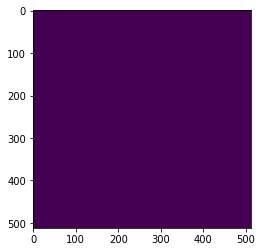

In [18]:
plt.imshow(segmentation_array[34,:,:])
plt.show()

In [19]:
#for i in range(output.shape[0]):
#    plt.imshow(segmentation_array[i,:,:])
#    plt.show()